# Assignment 2: Function Approximation for Q Learning

Name:

ID:

### 1. Cartpole

A cartpole problem is shown below.
![pendulum2.png](pendulum2.png)

The equation for the cartpole problem is nonlinear in nature, but it has been shown through robust control theory that a linear version of the equation of the form $\dot{x} = Ax+Bu$ can be solved by a linear controller. Let us assume that we are interested in minimizing cart stray from the center, and pendulum falling. It turns out that typical techniques - open loop control, PID control, root locus, etc. is not suitable for stabilizing both the cart position (keep near center) or the pole angle (keep vertical). The solution to this question is a linear quadratic controller, but we won't be using the solution at the moment.

### Setup Environment for Function Approximation


In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

# Create the CartPole game environment
env = gym.make('CartPole-v0')
state = env.reset()

WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.


(-inf, inf)

#### Demonstrate your understanding of the simulation
For OpenAI's CartPole-v0 environment,
- describe the reward system
- describe the each state variable (observation space)
- describe the action space

Ans: 



### Write a Deep Neural Network class that creates a dense network of a desired architecture
In this problem we will create neural network that is our function that takes states to q-values: $q=f(x)$. While any function approximator could be used (i.e. Chebyshev functions, taylor series polynomials), neural networks offer a most general form of 1st-order smooth function (though comprising of trivial small activation functions means that complex functions require a significant amount of weights to identify). 

Create a class for a QNetwork that uses PyTorch to create a fully connected sequential neural network, of the following properties:
- solver: Adam

- input and hidden layer activation function: tanh

- output activation function: linear

- loss: mse

- learning_rate: variable

- decay_rate: variable

- hidden_state sizes: variable

- state and action sizes: variable


In [70]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

def toVar(x):
    x = torch.from_numpy(x).float()
    x = Variable(x)
    return x

def toNp(var):
    return var.data.numpy()

class QNetwork(nn.Module):
# Define your network here       
    def __init__(self, learning_rate, state_size, action_size, hidden_size, alpha_decay):
        super(QNetwork, self).__init__()
        self.layer1 = nn.Linear(state_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, action_size)
        
        # Adam optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        
        # LR Scheduler
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=500, gamma=alpha_decay)
        
        # Mean squared error loss
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        x = F.tanh(self.layer1(x))
        x = F.tanh(self.layer2(x))
        x = self.layer3(x)
        return x
    
    def run_optimize(self, inputs, targets, mask):
        self.optimizer.zero_grad()
        outputs = self(inputs)
        self.loss = self.criterion(outputs, targets)
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()
    
    def copyWeights(self, other):
        self.load_state_dict(other.state_dict())

#### Write a Replay class that includes all the functionality of a replay buffer
The replay buffer should kept to some maximum size (10000), allow adding of samples and returning of samples at random from the buffer. Each sample (or experience) is formed as (state, action, reward, next_state, done). The replay buffer should also be able to generate a minibatch. The generate_minibatch method should take in DQN, targetDQN, selected batch_size, and return the states present in the minibatch and the target Q values for those states.

In [71]:
import random

class Replay(object):
# Replay should also have an initialize method which creates a minimum buffer for 
# the initial episodes to generate minibatches.
    def __init__(self, max_size):
        self.buffer = []
        self.capacity = max_size
        self.position = 0
        
    def add_exp(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (np.asarray(state), action, reward, np.asarray(next_state), done)
        self.position = (self.position+1)%self.capacity
    
    def initialize(self, init_length, envir):
        state = envir.reset()
        while(len(self.buffer)<init_length):
            state = envir.env.state
            action = envir.action_space.sample()
            next_state, reward, done, _ = envir.step(action)
            self.add_exp(state, action, reward, next_state, done)
            if done:
                state = envir.reset()
            else:
                state = next_state
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
            
    def generate_minibatch(self, DQN, targetDQN, batch_size, gamma):
        states = []
        target_qvalues = []
        actions = np.ones((batch_size,2))
        samples = self.sample(batch_size)
        counter = 0
        for state, action, reward, next_state, done in samples:
            # if done then qvalue is the reward itself
            # else it is reward+gamma*max(targetQ(s'))
            #if done:
            #    reward = 1
            max_qsa = reward
            if not done:
                target_q = toNp(targetDQN(toVar(next_state)))
                max_qsa += gamma*max(target_q)
            
            # qvalues for the action taken need to be optimized
            y = toNp(DQN(toVar(state)))
            y[action] = max_qsa
            actions[counter,action] = 1
            counter+=1
            states.append(state)
            target_qvalues.append(y)
            
            
        states = np.asarray(states)
        target_qvalues = np.asarray(target_qvalues)
        return states, actions, target_qvalues
                

Write a function that creates a minibatch from a buffer

### Perform Function Approximation
Initialize DQN networks and Replay objects

In [72]:
# Initialize DQN
# Play around with your learning rate, alpha decay and hidden layer units 
# Two layers with a small number of units should be enough
learning_rate = 0.001
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
hidden_size = 100
alpha_decay = 0.6
DQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)
targetDQN = QNetwork(learning_rate, state_size, action_size, hidden_size, alpha_decay)

# set targetDQN weights to DQN weights
# for ex. targetDQN.model.weights = DQN.model.weights (syntax given here is for representation purpose only)

## Initialize Replay Buffer
###################################
## Populate the initial experience buffer
###################################

replay = Replay(max_size=10000)
replay.initialize(init_length=1000, envir=env)

#### Create a function that solves the above environment using a deep Q network that uses a minibatch strategy.
Use the following parameters (these had to be derived empirically - there is generally no trusted way of choosing the right parameter values - i.e. gamma, number of episodes, decay rate, min_epsilon). 

Generate a graph of the average return per episode every 100 episodes.

In [73]:
# Runtime parameters
num_episodes = 2000            # max number of episodes to learn from
gamma = 0.95                   # future reward discount
max_steps = 1000                # cut off simulation after this many steps
batch_size = 250
C = 50

# Exploration parameters
min_epsilon = 0.001             # minimum exploration probability
decay_rate = 5.0/num_episodes    # exponential decay rate for exploration prob
returns = np.zeros(num_episodes)

for ep in range(0, num_episodes):
    epsilon = min_epsilon + (1.0 - min_epsilon)*np.exp(-decay_rate*ep)
    state = env.reset()
    total_reward = 0.0
    while True:
    #for step in range(max_steps):
        # --> start episode
        q_sa = toNp(DQN(toVar(state)))
        action = np.argmax(q_sa)
        
        # explore/exploit and get action using DQN
        # binary action space
        if np.random.rand()<epsilon:
            action = 1-action
            
        # perform action and record new_state, action, reward
        next_state, reward, done, _ = env.step(action)
        total_reward += reward
        
        # populate Replay experience buffer
        replay.add_exp(state, action, reward, next_state, done)
        
        if done:
            reward = 1
            break
        else:
            state = next_state
        # <-- end episode

    returns[ep] = total_reward

    # Replay
    states, actions, target_qvalues = replay.generate_minibatch(DQN, targetDQN, batch_size, gamma)
    
    # set targetDQN weights to DQN weights
    if (ep+1)%C==0:
        print(ep+1, returns[ep])
        targetDQN.copyWeights(DQN)
    
    # update DQN (run one epoch of training per episode with generated minibatch of states and qvalues)
    #for i in range(states.shape[0]):
    #    DQN.run_optimize(toVar(states[i]), toVar(target_qvalues[i]))
    DQN.run_optimize(toVar(states), toVar(target_qvalues), toVar(actions))        

(50, 200.0)
(100, 13.0)
(150, 21.0)
(200, 17.0)
(250, 31.0)
(300, 40.0)
(350, 23.0)
(400, 37.0)
(450, 48.0)
(500, 54.0)
(550, 84.0)
(600, 200.0)
(650, 200.0)
(700, 200.0)
(750, 200.0)
(800, 200.0)
(850, 200.0)
(900, 195.0)
(950, 200.0)
(1000, 200.0)
(1050, 200.0)
(1100, 200.0)
(1150, 194.0)
(1200, 200.0)
(1250, 200.0)
(1300, 200.0)
(1350, 200.0)
(1400, 191.0)
(1450, 200.0)
(1500, 173.0)
(1550, 189.0)
(1600, 200.0)
(1650, 200.0)
(1700, 200.0)
(1750, 184.0)
(1800, 200.0)
(1850, 200.0)
(1900, 178.0)
(1950, 200.0)
(2000, 200.0)


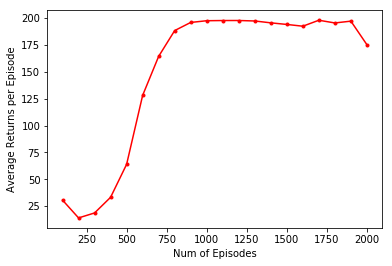

In [74]:
# plot average returns
returns_over_100_episodes = []
x = []
for i in range(0,int(num_episodes/100)):
    returns_over_100_episodes.append(sum(returns[100*i:100*(i+1)-1])/100)
    x.append((i+1)*100)
plt.plot(x,returns_over_100_episodes,'.-r')
plt.ylabel('Average Returns per Episode')
plt.xlabel('Num of Episodes')
plt.show()
    

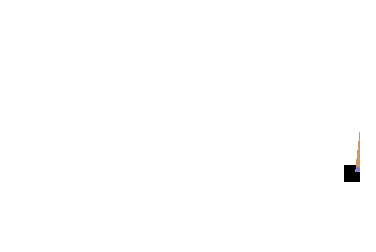

{0: 76, 1: 84}


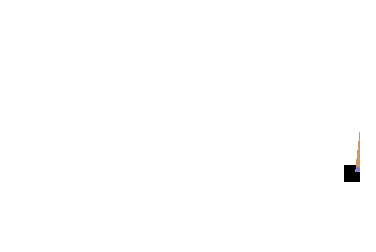

In [29]:
# DEMO FINAL NETWORK
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


env = gym.make('CartPole-v0')
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())
state = np.reshape(state, [1, state.size])
total_reward = 0
for i in range(0, max_steps):
    #env.render()
    show_state(env,i)
    
    Qs = toNp(DQN(toVar(state)))
    # Get action from Q-network
    # Qs = output of DQN.model when state is passed in
    action = np.argmax(Qs)
    
    # Take action, get new state and reward
    next_state, reward, done, _ = env.step(action)
    total_reward += reward

    if done:
        #env.close()
        break
    else:
        state = np.reshape(next_state, [1, state.size])

In [27]:
print(count)

{0: 69, 1: 79}
